In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cm
import pandas as pd
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools
from salishsea_tools import visualisations as vis
import matplotlib as mpl
import netCDF4 as nc

## Functions and Files

In [4]:
vol_mon_2019 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2019, 2019))
vol_mon_2020 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2020, 2020))
vol_mon_2021 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2021, 2021))
vol_mon_2022 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2022, 2022))
vol_mon_2023 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2023, 2023))

In [5]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]
tmask = tmask.rename({'z' : 'depth', 'y': 'gridY', 'x': 'gridX'})

mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh_mask_depth_var='gdept_0'
# bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

In [6]:
thalweg_file = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
mesh_mask_depth_var='gdept_0'
depth = mesh.variables[mesh_mask_depth_var][:]

In [52]:
def plot_field_12_months_sum(p_var, cmap, ds, tmask, year, vol_mon):
    nrow = 3
    ncol = 4

    fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
    cmap.set_bad('gray')

    fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

    for row in np.arange(nrow):
        for col in np.arange(ncol):
            time_idx = row * ncol + col
            salinity = np.ma.masked_array(ds[p_var][time_idx], mask=tmask[0])
            colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
            dtime = pd.to_datetime(ds['time'].values[time_idx])
            ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
            viz_tools.set_aspect(ax[row,col]);

    cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, vol_mon[p_var].units))

    # plt.savefig('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/monthly_vis/hindcast_auto/mean/{}.png'.format(fname))

In [8]:
X1 = vol_mon_2019['gridX'].values
Y1 = vol_mon_2019['gridY'].values

In [38]:
def plot_diff_12_months(cmap, year_ds, tmask, year, p_var):
    array = year_ds[p_var] - river_mon_mean
    cmap = mpl.colormaps['RdBu_r']
    nrow = 3
    ncol = 4

    # fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
    cmap.set_bad('gray')

    fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

    max_abs = np.max(np.abs(array))
    # cont_vals = [-max_abs*.75, max_abs*.75]
    for row in np.arange(nrow):
        for col in np.arange(ncol):
            time_idx = row * ncol + col
            salinity = np.ma.masked_array(array[time_idx], mask=tmask[0])
            colours = ax[row,col].pcolormesh(salinity, vmin=-max_abs, vmax=max_abs, cmap=cmap)
            dtime = pd.to_datetime(vol_mon_2019['time'].values[time_idx])
            ax[row,col].set_title('{} {}'.format(dtime.month_name(), year))
            viz_tools.set_aspect(ax[row,col]);

            Z1 = salinity
            
            # cont1 = ax[row,col].contour(X1, Y1, Z1, cont_vals, colors='green')

    
    cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, vol_mon_2019[p_var].units))

In [17]:
def plot_thalweg_12_months(year, ds, p_var, ymin, ymax, cmap):

    var_thals = []
    for time_idx in range(0,12):
        dep_thal, distance, var_thal = vis.load_thalweg(
                depth[0, ...], np.array(ds[p_var][time_idx]), bathy['nav_lon'][:], bathy['nav_lat'][:],
                thalweg_pts)
        var_thals = var_thals + [var_thal]
    var_thals_arr = np.array(var_thals)
    global_max = np.floor(var_thals_arr.max()/1000)*1000
    global_min = global_max/10
    
    fig, axs = plt.subplots(12, 1, figsize=(12, 35))
    jp = 0
    levels = np.linspace(global_min, round(global_max), 10)
    cont_max=global_max
    for month in range(1, 13):
        time_idx = month-1
        var_thal = var_thals[time_idx]
        var_plot = vis._fill_in_bathy(var_thal, mesh, thalweg_pts)
        colours = axs[jp].contourf(distance, dep_thal, var_plot, 
                                cmap=cmap, extend='both', zorder=-1, levels=levels)
        axs[jp].contour(distance, dep_thal, var_plot, levels, 
                                colors='black', zorder=0)
        vis._add_bathy_patch(
                distance, bathy['Bathymetry'][:], thalweg_pts, axs[jp], color='burlywood')
        cbar = fig.colorbar(colours, ax=axs[jp], label='{} [{}]'.format(p_var, ds[p_var].units))
        axs[jp].invert_yaxis()
        axs[jp].set_ylim(ymax, ymin)
        axs[jp].set_ylabel('Depth [m]');
        axs[jp].set_xlabel('Distance along thalweg [km]')
        dtime = pd.to_datetime(ds['time'].values[time_idx])
        axs[jp].set_title('{} {}'.format(dtime.month_name(), year))
        jp = jp + 1;
    fig.tight_layout();

In [11]:
river_mon_2023 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2023, 2023))
river_mon_2022 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2022, 2022))
river_mon_2021 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2021, 2021))
river_mon_2020 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2020, 2020))
river_mon_2019 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2019, 2019))

In [10]:
this_p_var = 'homathko_river'

In [14]:
river_mon_mean = np.mean([river_mon_2019[this_p_var], river_mon_2020[this_p_var], river_mon_2021[this_p_var], river_mon_2022[this_p_var], river_mon_2023[this_p_var]], axis=0)
river_mon_year_mean = np.mean(river_mon_mean, axis=0)

## Means and Diffs

these all look very similar, but can see later when river_mon_mean - river_mon_year_mean that they are different

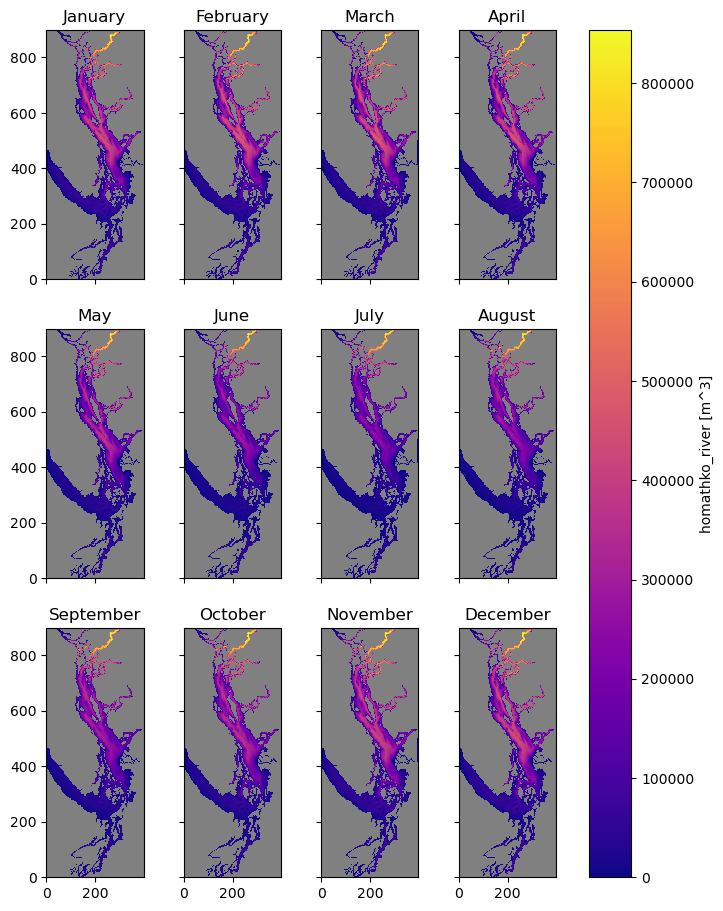

In [15]:
# array = river_mon_mean
cmap = mpl.colormaps['plasma']
nrow = 3
ncol = 4
fudge = 0.001

# fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(river_mon_mean[time_idx], mask=tmask[0])
        colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
        # colours = ax[row,col].pcolormesh(salinity, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
        dtime = pd.to_datetime(vol_mon_2019['time'].values[time_idx])
        ax[row,col].set_title('{}'.format(dtime.month_name()))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(this_p_var, vol_mon_2019[this_p_var].units))

In [16]:
meshmask = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh_mask_depth_var='gdept_0'
thalweg_file = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
depth = mesh.variables[mesh_mask_depth_var][:]
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)

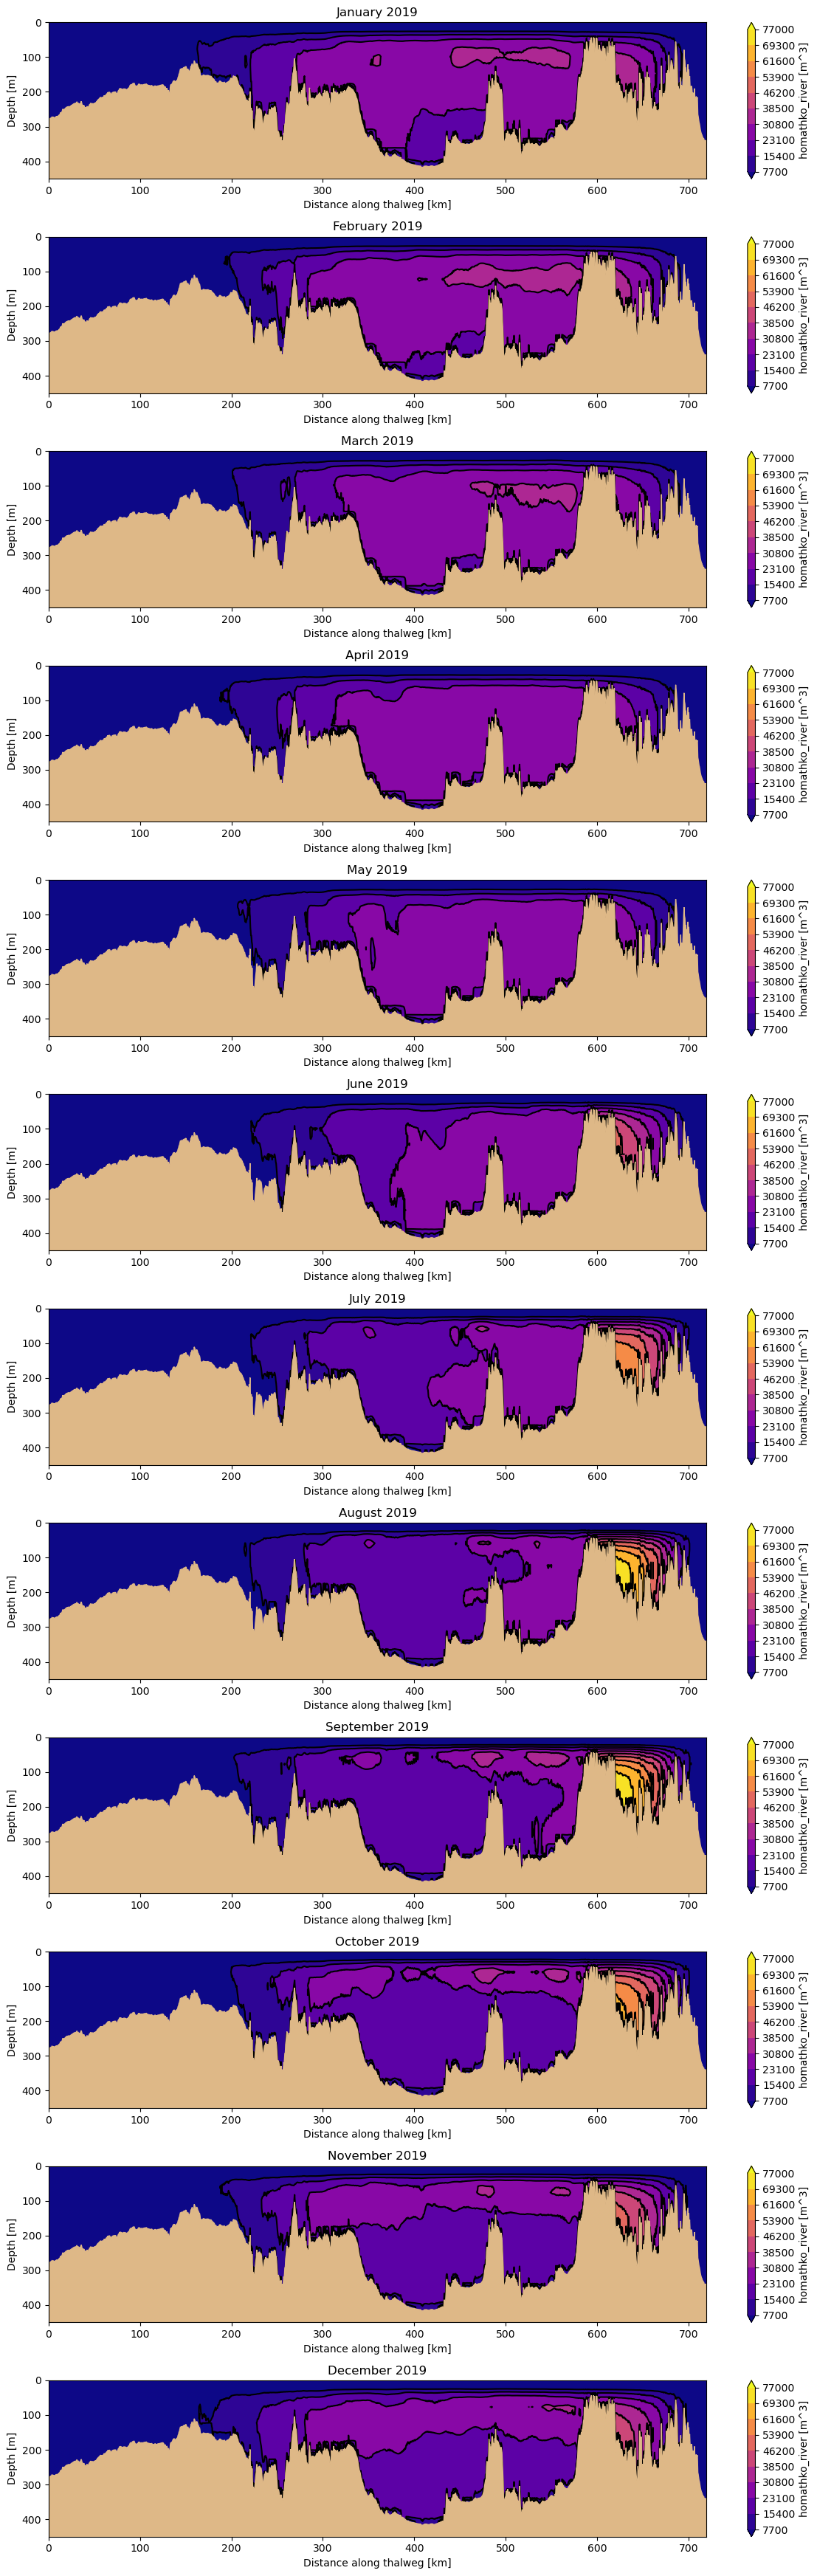

In [18]:
plot_thalweg_12_months('2019', vol_mon_2019, this_p_var, 0, 450, 'plasma')

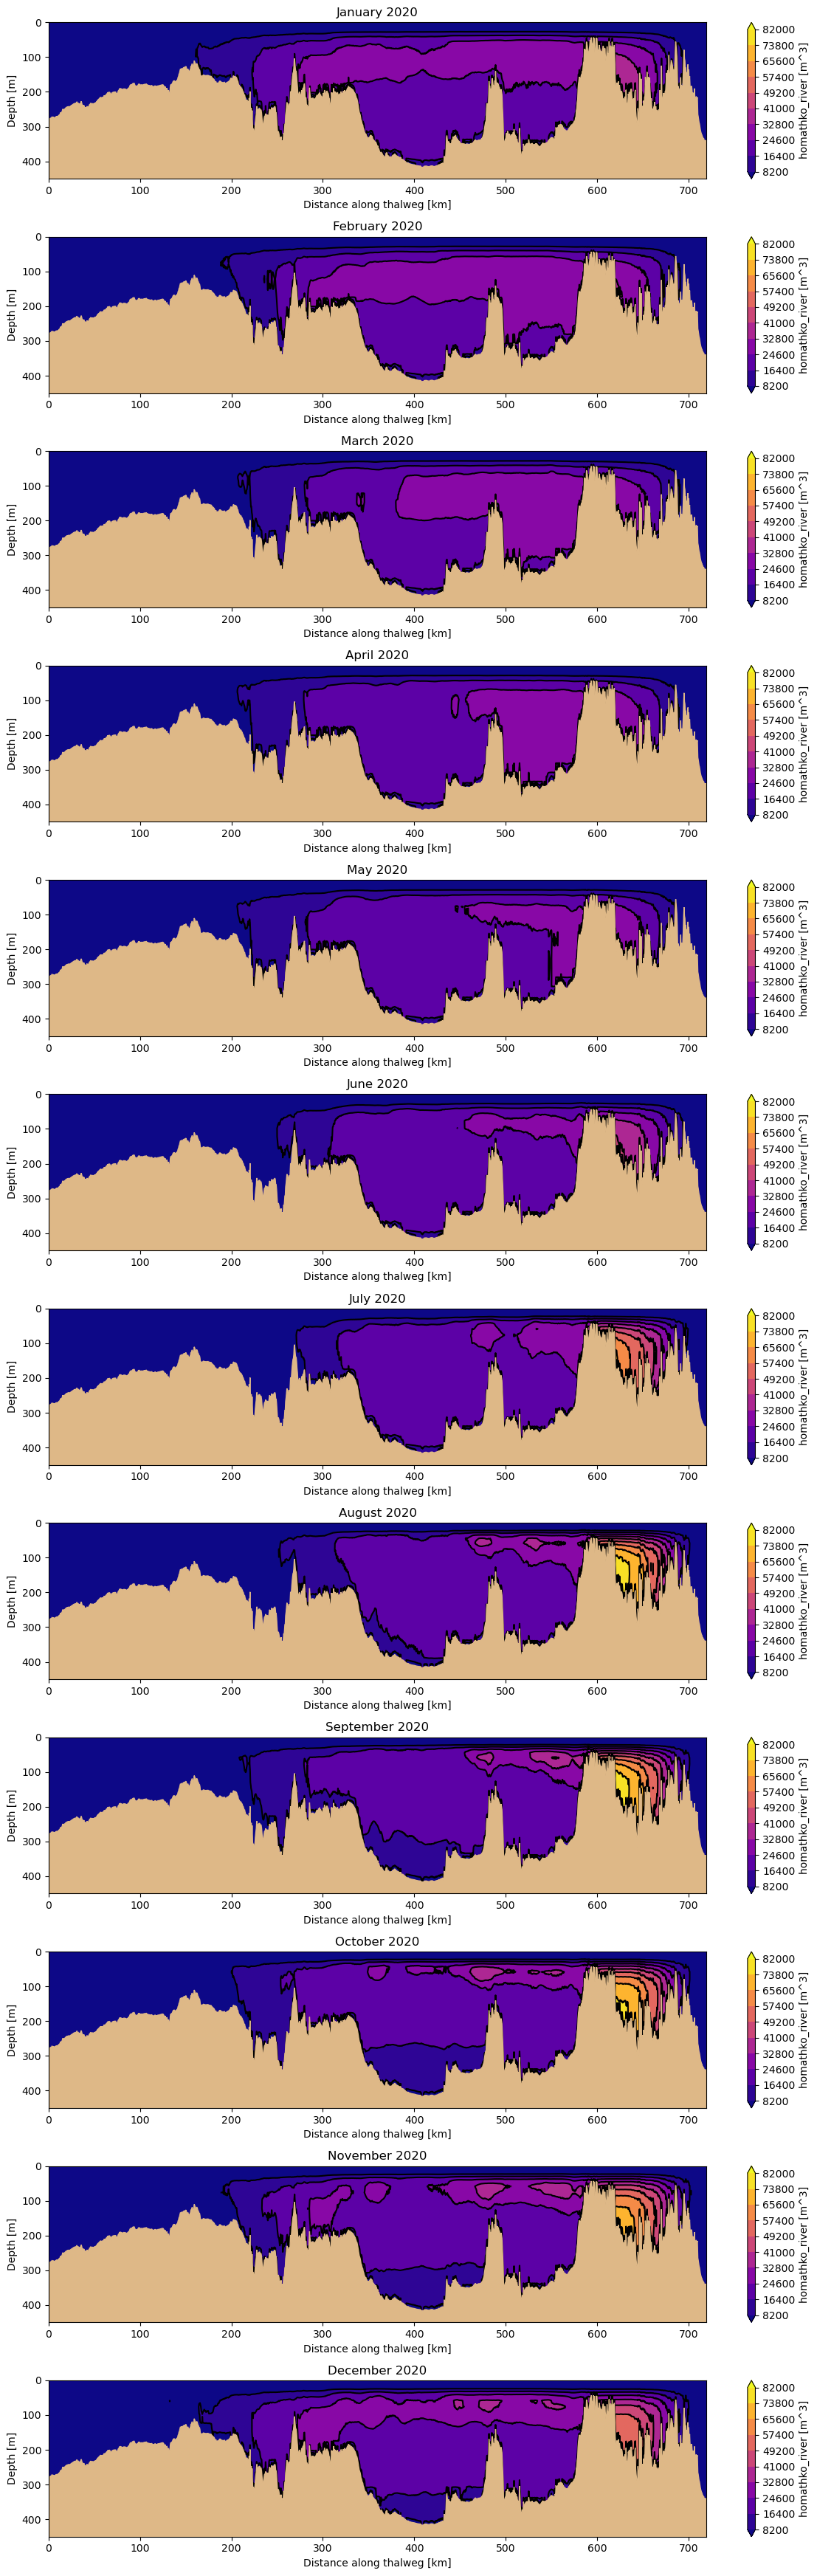

In [62]:
plot_thalweg_12_months('2020', vol_mon_2020, this_p_var, 0, 450, 'plasma')

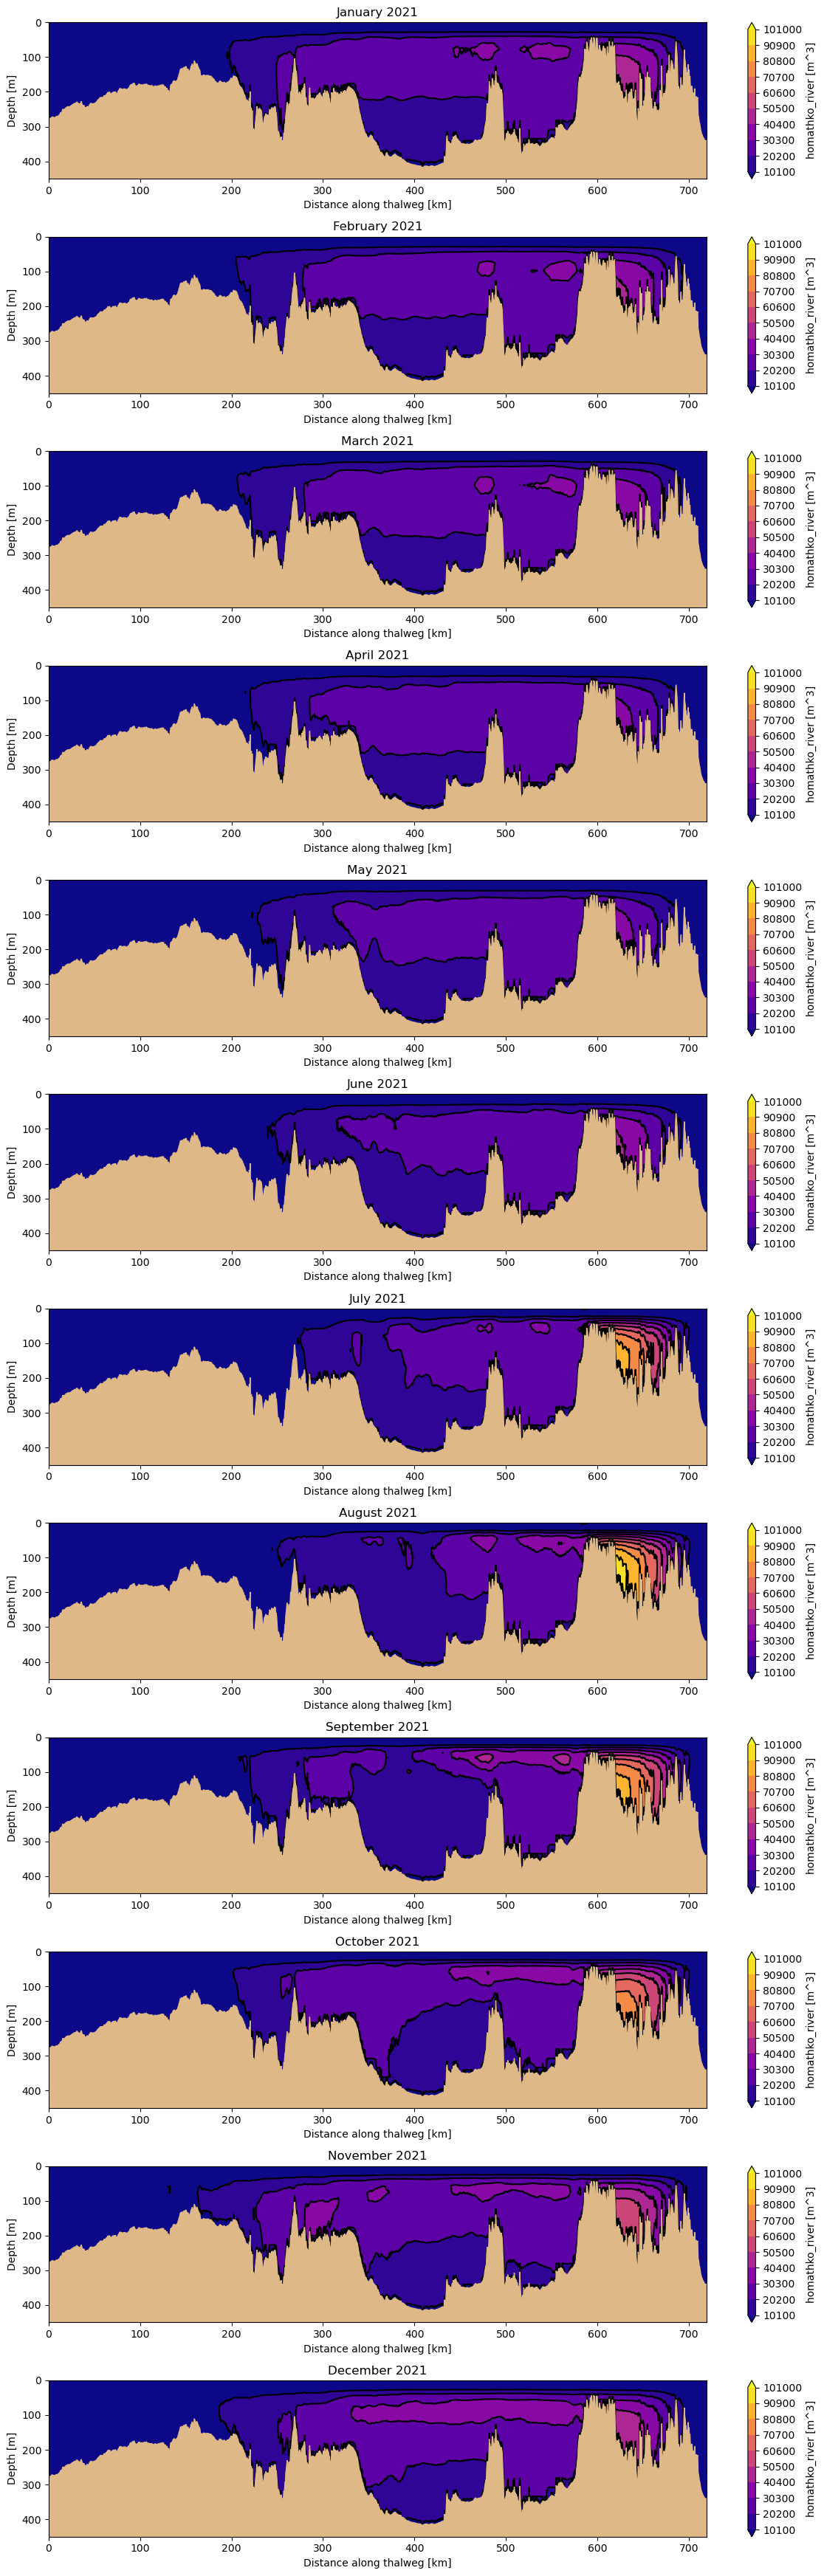

In [63]:
plot_thalweg_12_months('2021', vol_mon_2021, this_p_var, 0, 450, 'plasma')

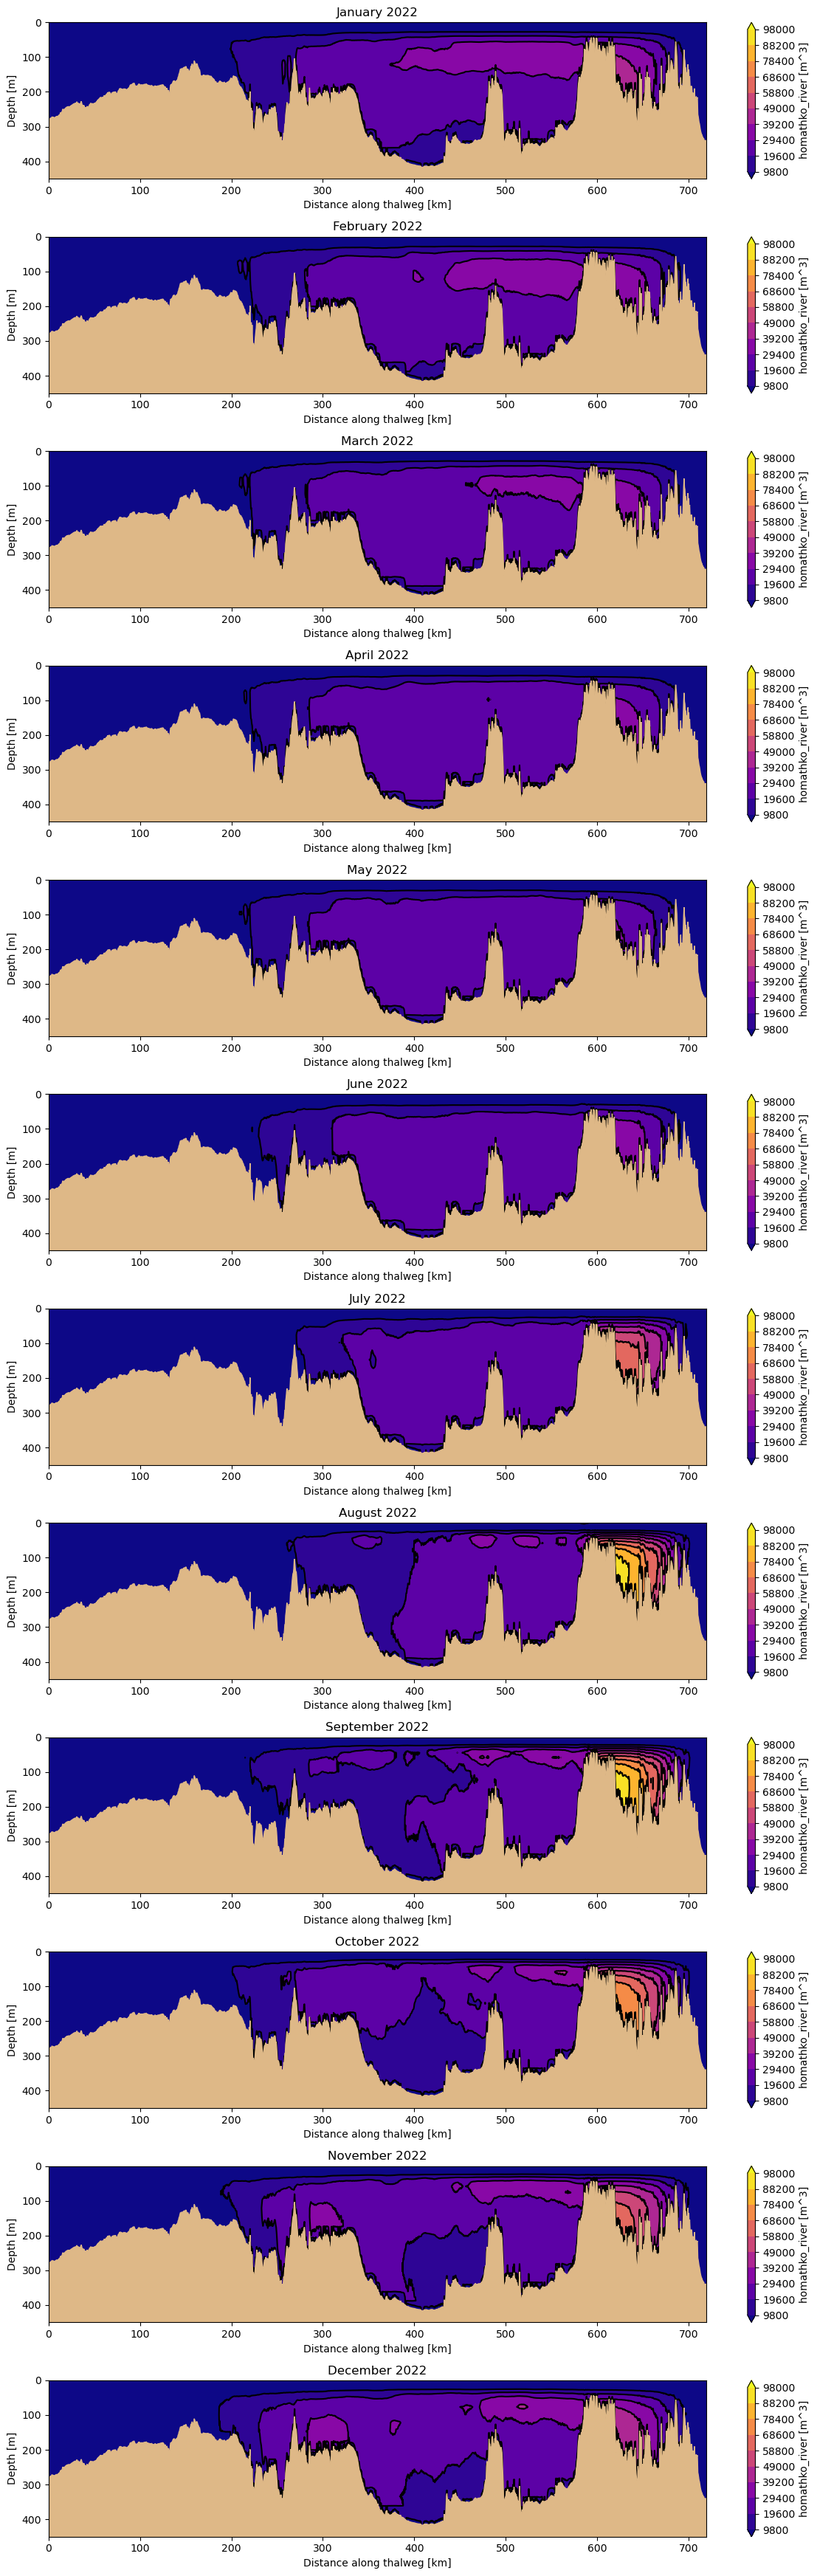

In [64]:
plot_thalweg_12_months('2022', vol_mon_2022, this_p_var, 0, 450, 'plasma')

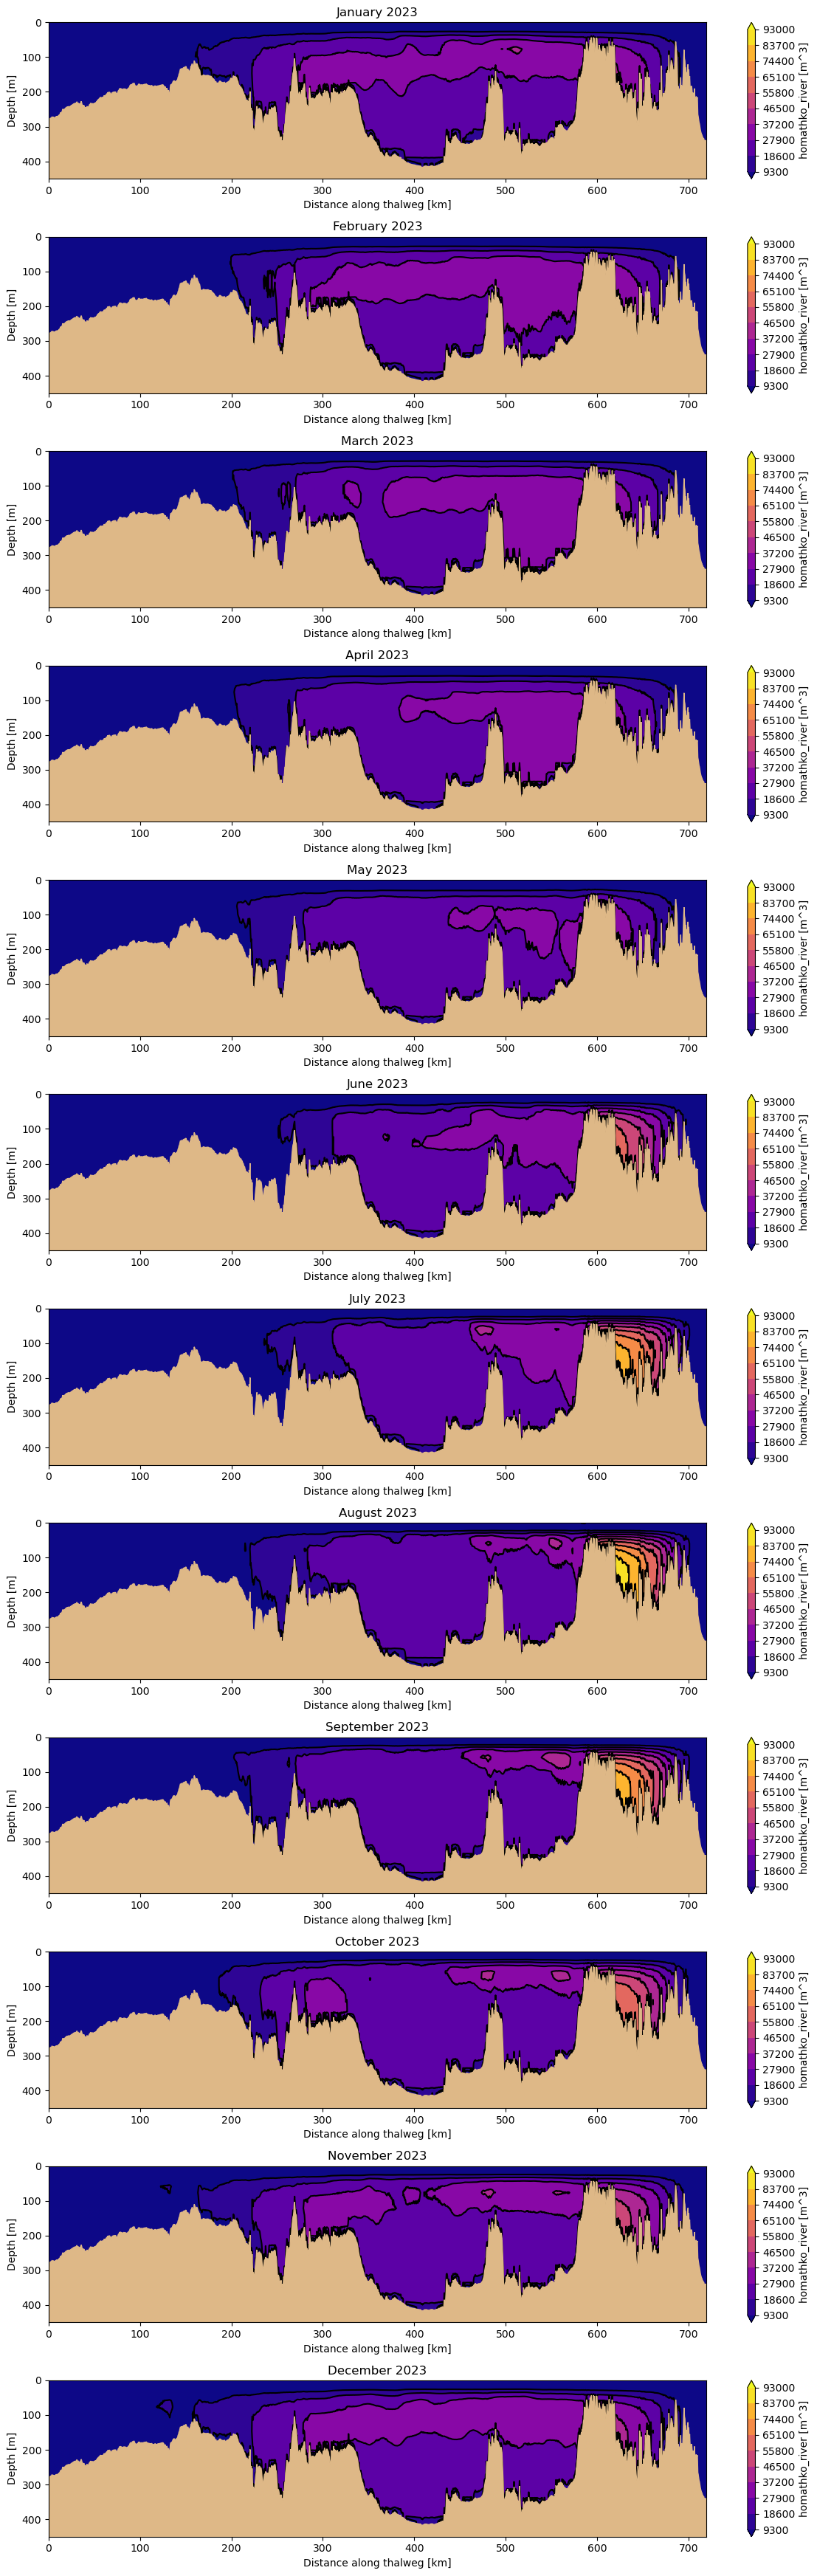

In [65]:
plot_thalweg_12_months('2023', vol_mon_2023, this_p_var, 0, 450, 'plasma')

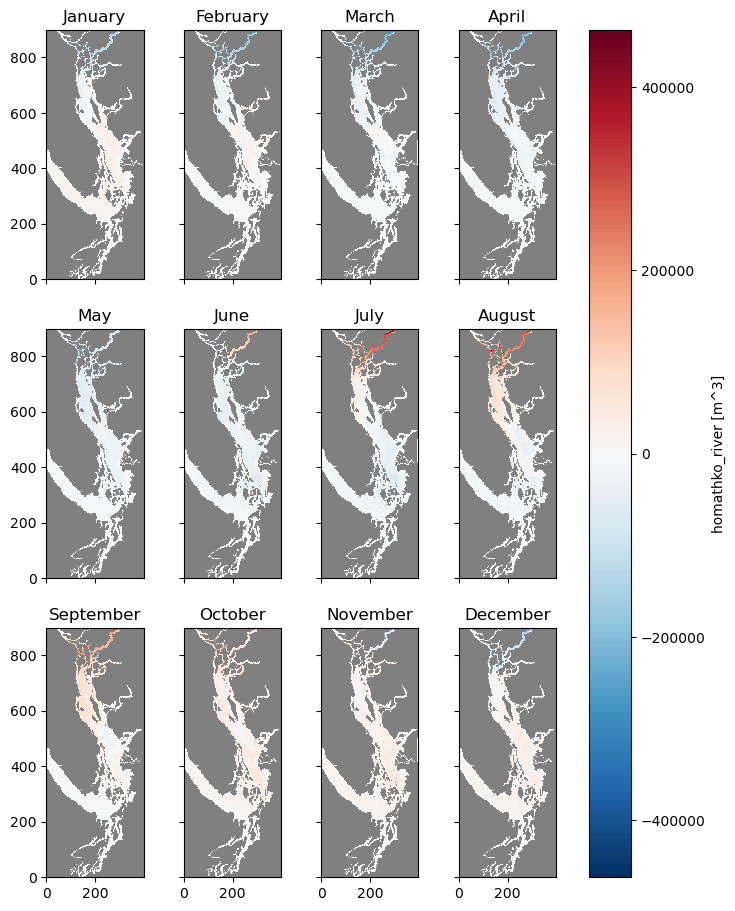

In [19]:
array = river_mon_mean - river_mon_year_mean  # check this order
cmap = mpl.colormaps['RdBu_r']
nrow = 3
ncol = 4
fudge = 0.001

# fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

max_abs = np.max(np.abs(array))
for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(array[time_idx], mask=tmask[0])
        colours = ax[row,col].pcolormesh(salinity, vmin=-max_abs, vmax=max_abs, cmap=cmap)
        # colours = ax[row,col].pcolormesh(salinity, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
        dtime = pd.to_datetime(vol_mon_2019['time'].values[time_idx])
        ax[row,col].set_title('{}'.format(dtime.month_name()))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(this_p_var, vol_mon_2019[this_p_var].units))

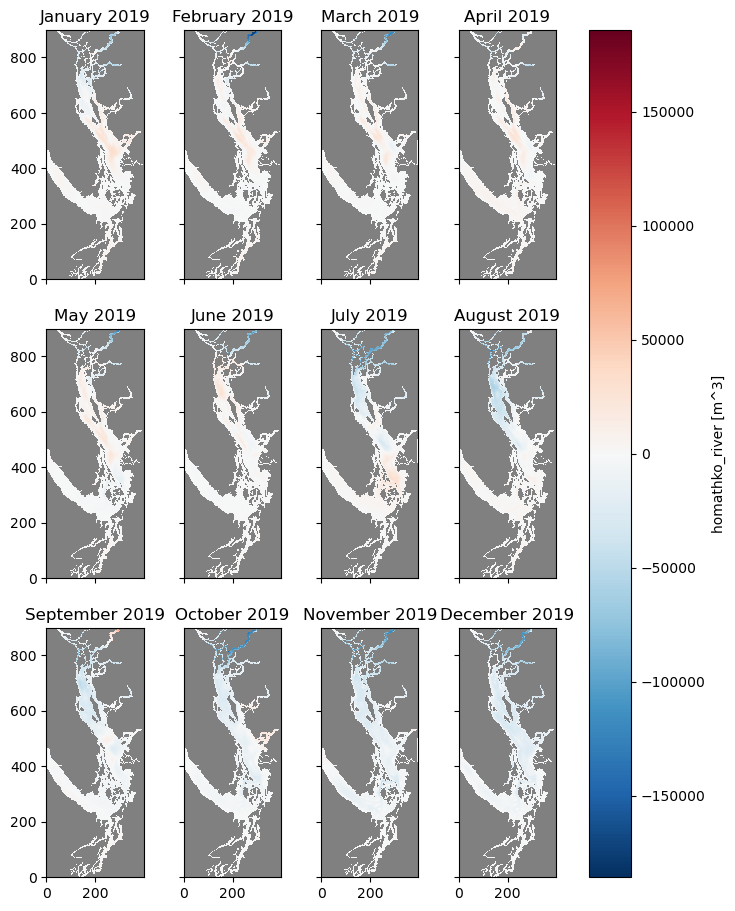

In [26]:
plot_diff_12_months(mpl.colormaps['RdBu_r'], river_mon_2019, tmask, '2019', this_p_var)

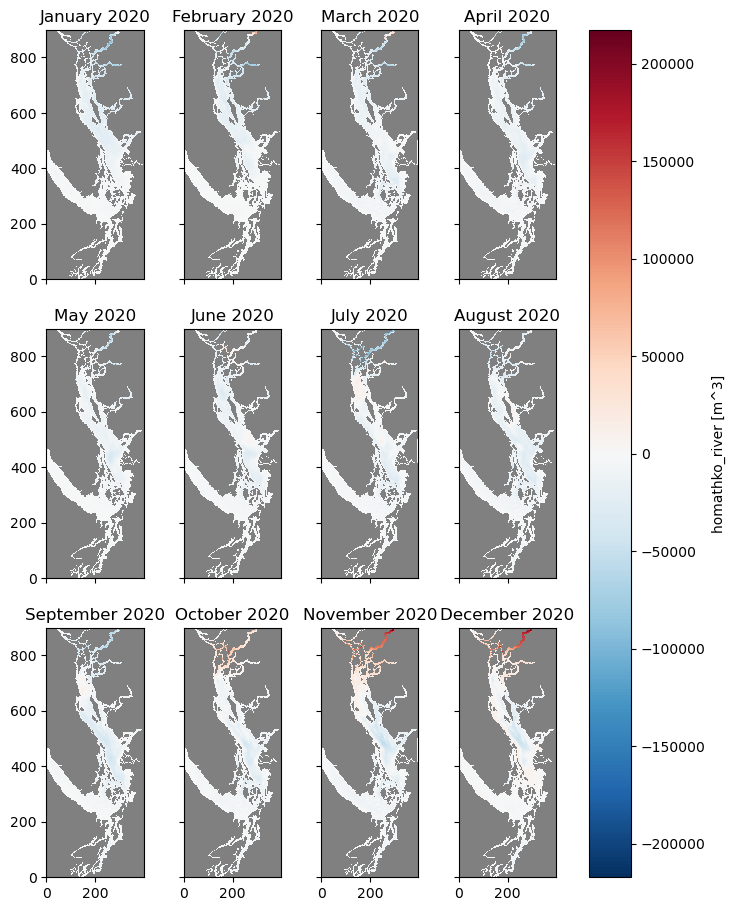

In [27]:
plot_diff_12_months(mpl.colormaps['RdBu_r'], river_mon_2020, tmask, '2020', this_p_var)

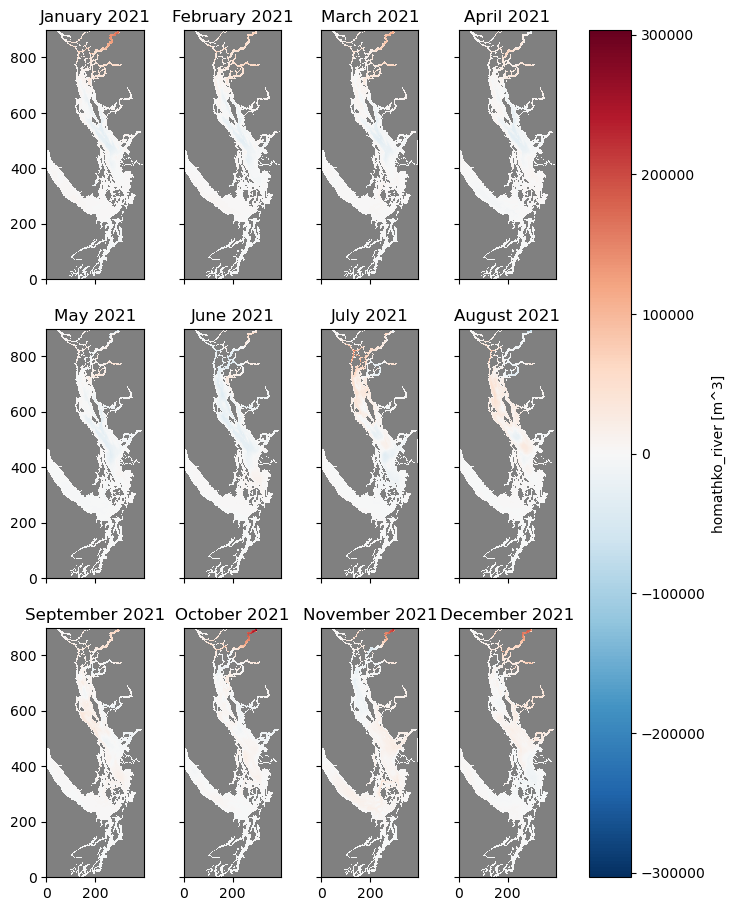

In [28]:
plot_diff_12_months(mpl.colormaps['RdBu_r'], river_mon_2021, tmask, '2021', this_p_var)

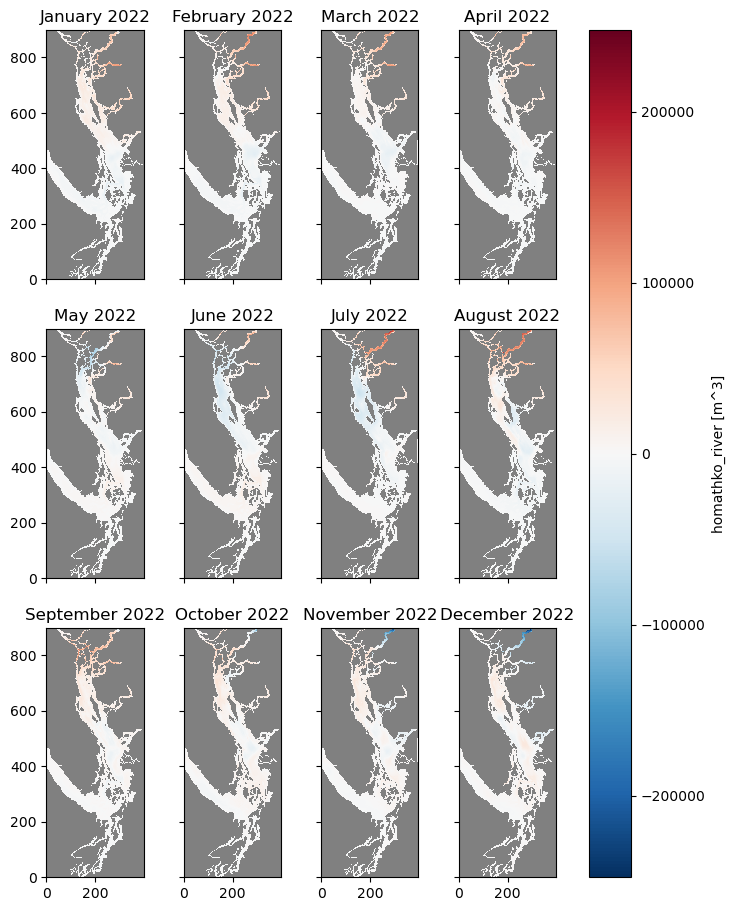

In [29]:
plot_diff_12_months(mpl.colormaps['RdBu_r'], river_mon_2022, tmask, '2022', this_p_var)

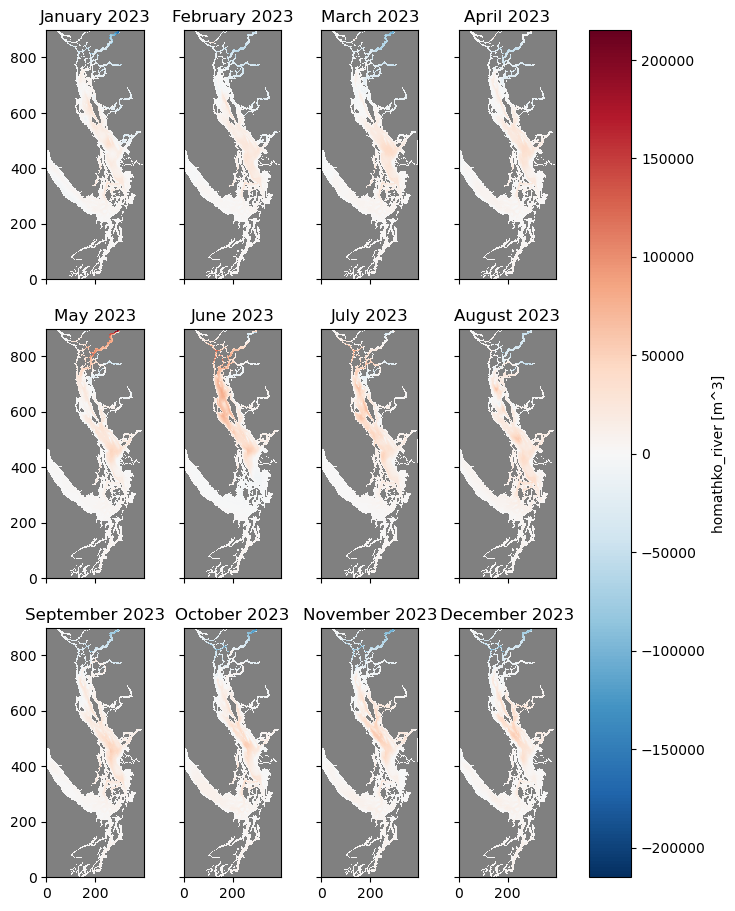

In [30]:
plot_diff_12_months(mpl.colormaps['RdBu_r'], river_mon_2023, tmask, '2023', this_p_var)

## Yearly Slice Plots

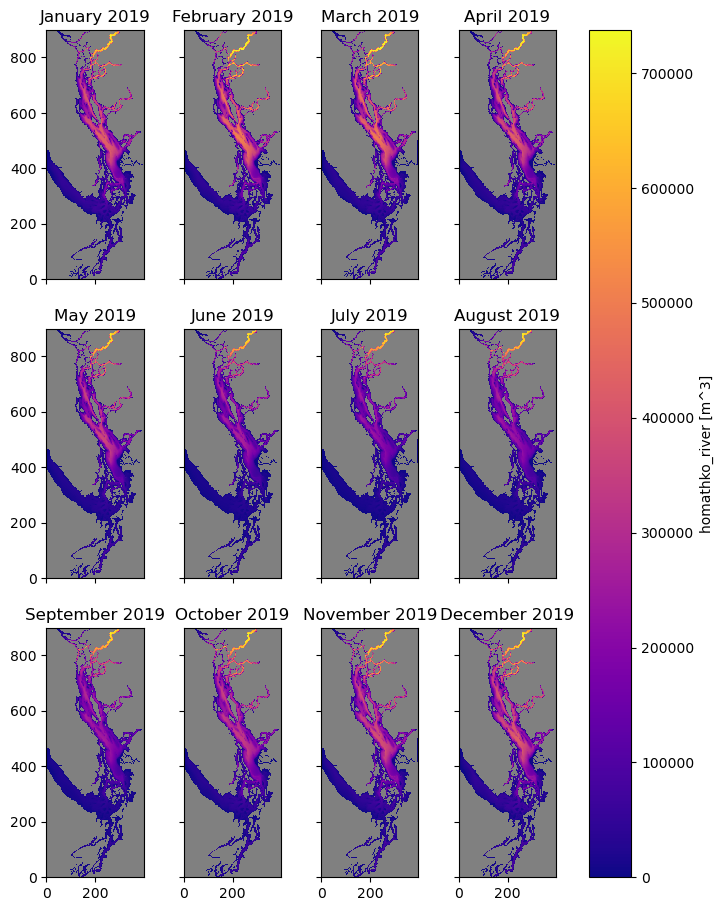

In [53]:
plot_field_12_months_sum(this_p_var, mpl.colormaps['plasma'], river_mon_2019, tmask, 2019, vol_mon_2019)

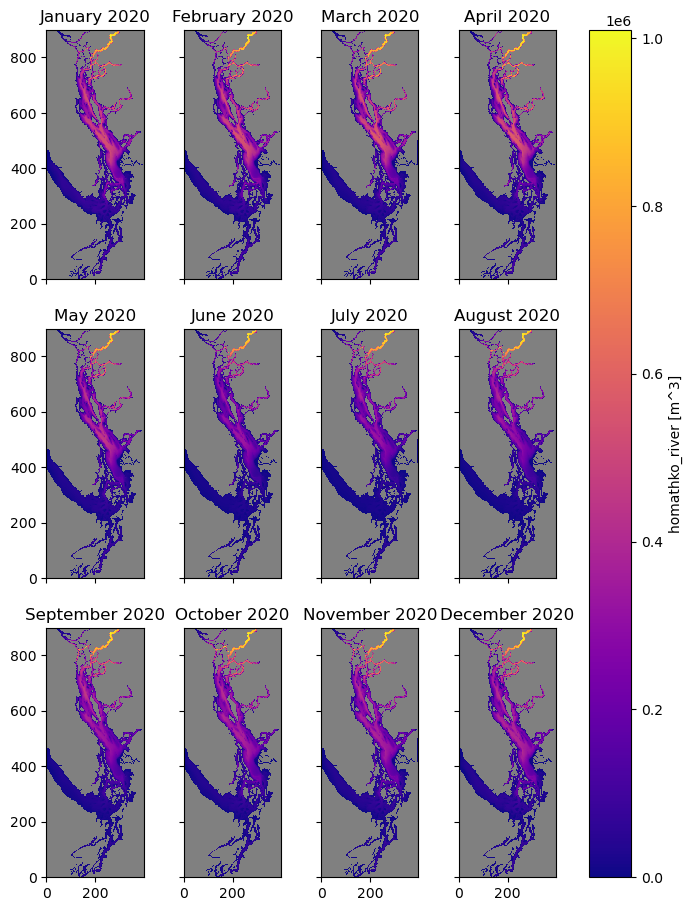

In [57]:
plot_field_12_months_sum(this_p_var, mpl.colormaps['plasma'], river_mon_2020, tmask, 2020, vol_mon_2020)

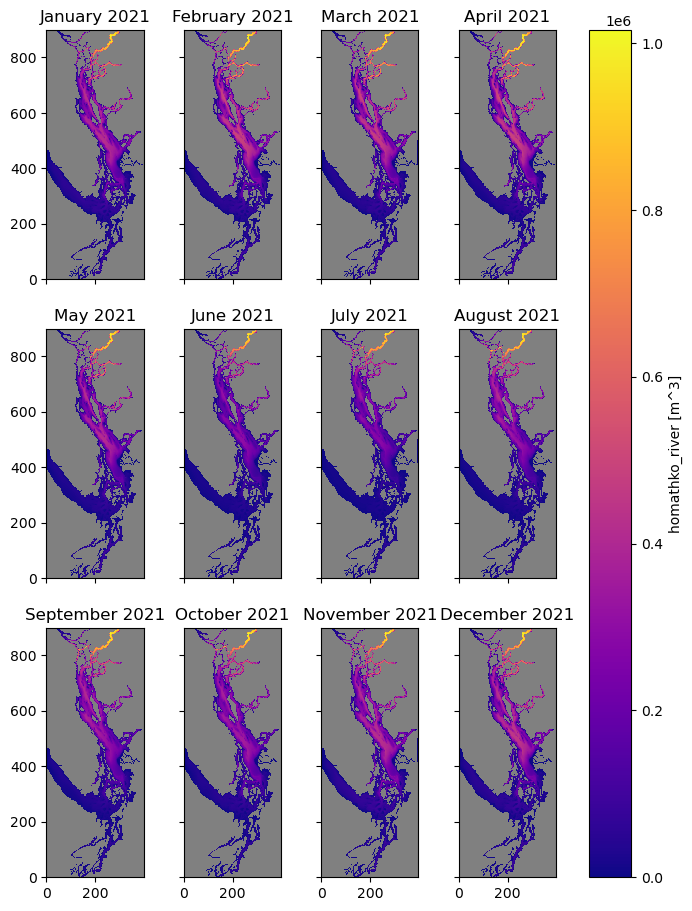

In [59]:
plot_field_12_months_sum(this_p_var, mpl.colormaps['plasma'], river_mon_2021, tmask, 2021, vol_mon_2021)

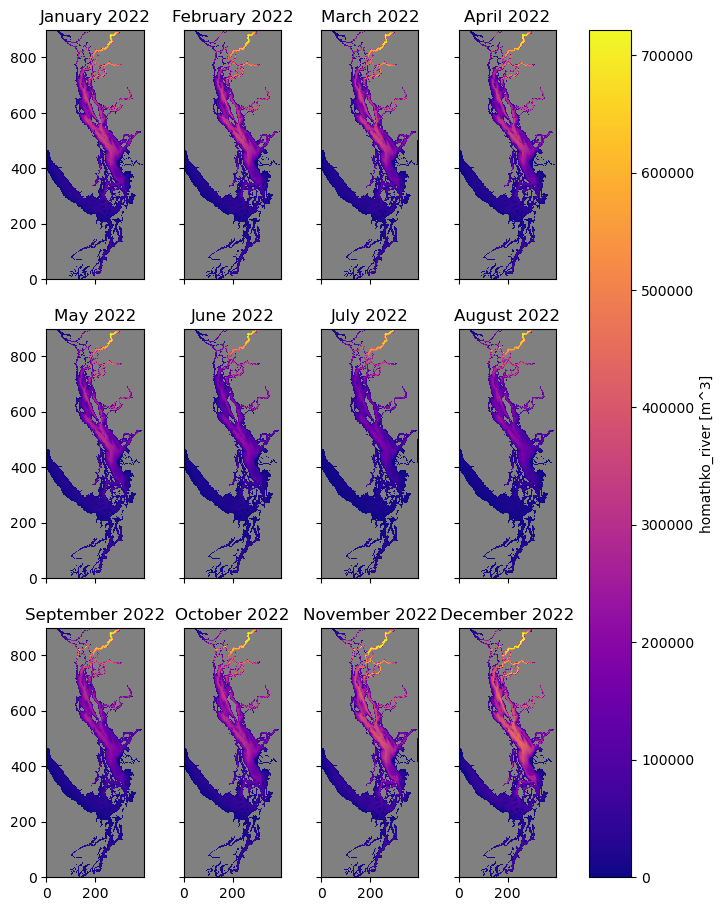

In [60]:
plot_field_12_months_sum(this_p_var, mpl.colormaps['plasma'], river_mon_2022, tmask, 2022, vol_mon_2022)

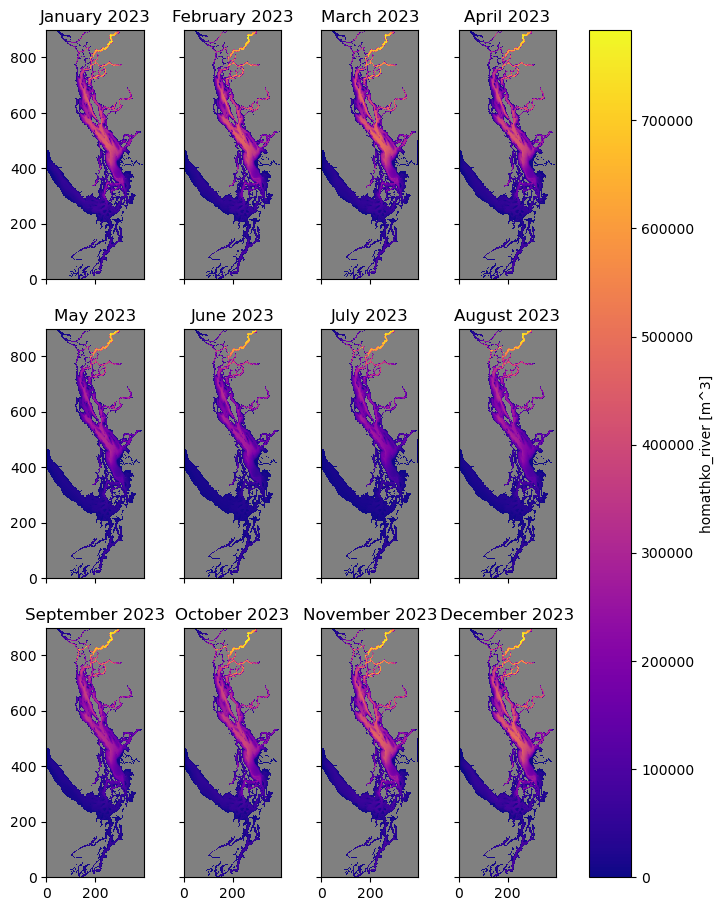

In [61]:
plot_field_12_months_sum(this_p_var, mpl.colormaps['plasma'], river_mon_2023, tmask, 2023, vol_mon_2023)